In [1]:
from math import sqrt
import numpy as np
import matplotlib.path as mpl_path
import matplotlib.pyplot as plt
import pre_processing as pp
import csv
import pandas as pd
import tensorflow as tf
from point_grid import *

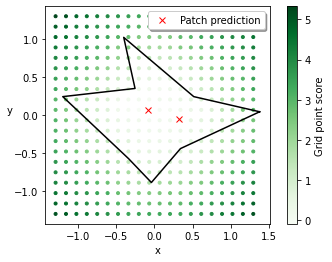

In [10]:
# Grid prediction
def grid_prediction(contour, internal_node_count, grid_model):

    # Build point grid
    point_grid = generate_point_grid()
    patches = generate_patches(point_grid)

    # Pre-process contour with procrustes superimposition
    transformed_contour = pp.procrustes(contour)['transformed_contour'] 
    transformed_contour_data = [coordinate for point in transformed_contour for coordinate in point]

    # Get patch data
    for patch in patches:
        patch_data = [coordinate for point in patch for coordinate in point.get_coordinates()]

        # Define prediction data
        features = np.append(transformed_contour_data, patch_data)
        prediction_data = np.expand_dims(features, axis=0)

        # Predict
        prediction_result = grid_model(prediction_data).numpy()

        # Write predicted score to the point grid
        for i, p in enumerate(patch):
            p.score = prediction_result[0][i] 

    return point_grid

import gmsh

grid_model_path = 'auto-model/nn2-8gon-2int'
grid_model = tf.keras.models.load_model(grid_model_path)

meshed_internal_node_count = -1
target_internal_node_count = 2
edge_count = 8


gmsh.initialize()
# Naive way of only checking the results on contours that the reference mesher would insert n points into
while meshed_internal_node_count != target_internal_node_count:
    contour = pp.create_random_ngon(edge_count)
    transformed_contour = pp.procrustes(contour)['transformed_contour']

    meshed_contour = pp.mesh_contour(transformed_contour, 0.4)
    meshed_internal_points = meshed_contour[-target_internal_node_count*2:]
    meshed_internal_node_count = int(meshed_contour[2*edge_count])
gmsh.finalize()

reference_nodes = list(zip(meshed_internal_points[::2], meshed_internal_points[1::2]))

# Predict the point grid and intrapolate nodes from it.
predicted_point_grid = grid_prediction(transformed_contour, target_internal_node_count, grid_model)
grid_prediction = generate_internal_nodes_from_grid_score(predicted_point_grid, target_internal_node_count)


"""
|-------------------------
|       PLOTTING
|-------------------------
"""
flat_pgp = [point for row in predicted_point_grid for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

pl1 = plt.plot([x[0] for x in grid_prediction], [y[1] for y in grid_prediction], 'rx', label="Patch prediction")
# Plot transformed contour
pl3 = pp.plot_polygon(transformed_contour, style='k')

# Plot point grid
pl4 = plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar(label="Grid point score")
plt.legend(loc='upper right', shadow='true')
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.gca().set_aspect('equal')